# M5 - FORECASTING - ACCURACY

## 1. INITIATION & READING DATA

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_colwidth', -1)

import seaborn as sns
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


from sklearn import feature_selection
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

print('** M5 - FORECASTING - ACCURACY **')
print("-"*25)

import gc
import os
for x in os.listdir("input/"):
    print(x)
print("-"*25)

print ("Initiation is DONE !!")
print("-"*25)

** M5 - FORECASTING - ACCURACY **
-------------------------
calendar.csv
sales_train_evaluation.csv
sales_train_validation.csv
sample_submission.csv
sell_prices.csv
-------------------------
Initiation is DONE !!
-------------------------


In [2]:
##### SOME USEFULL FUNCTIONS

## TIMER
import time
from contextlib import contextmanager
@contextmanager
def timer():
    t0 = time.time()
    yield
    t1 = time.time()
    print( 'Runtime: ' + str(round(t1-t0,2)) + ' sn' )

In [3]:
path = 'input/'

with timer():
    calendar   = pd.read_csv( f'{path}calendar.csv')
#    train_v    = pd.read_csv( f'{path}sales_train_validation.csv')
    train    = pd.read_csv( f'{path}sales_train_evaluation.csv')
    prices     = pd.read_csv( f'{path}sell_prices.csv')
    submission = pd.read_csv( f'{path}sample_submission.csv')

print('Reading Data is DONE !!')
print("-"*25)

print( f'calendar   shape :  {calendar.shape}    ')
#print( f'train_v    shape :  {train_v.shape}     ')
print( f'train    shape :  {train.shape}     ')
print( f'prices     shape :  {prices.shape}      ')
print( f'submission shape :  {submission.shape}  ')

Runtime: 5.49 sn
Reading Data is DONE !!
-------------------------
calendar   shape :  (1969, 14)    
train    shape :  (30490, 1947)     
prices     shape :  (6841121, 4)      
submission shape :  (60980, 29)  


## 2. TRAIN DATA - BASIC PREPROCESSING

In [4]:
print(train.shape)
print('-'*25)
train.head()

(30490, 1947)
-------------------------


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,...,d_1443,d_1444,d_1445,d_1446,d_1447,d_1448,d_1449,d_1450,d_1451,d_1452,d_1453,d_1454,d_1455,d_1456,d_1457,d_1458,d_1459,d_1460,d_1461,d_1462,d_1463,d_1464,d_1465,d_1466,d_1467,d_1468,d_1469,d_1470,d_1471,d_1472,d_1473,d_1474,d_1475,d_1476,d_1477,d_1478,d_1479,d_1480,d_1481,d_1482,d_1483,d_1484,d_1485,d_1486,d_1487,d_1488,d_1489,d_1490,d_1491,d_1492,d_1493,d_1494,d_1495,d_1496,d_1497,d_1498,d_1499,d_1500,d_1501,d_1502,d_1503,d_1504,d_1505,d_1506,d_1507,d_1508,d_1509,d_1510,d_1511,d_1512,d_1513,d_1514,d_1515,d_1516,d_1517,d_1518,d_1519,d_1520,d_1521,d_1522,d_1523,d_1524,d_1525,d_1526,d_1527,d_1528,d_1529,d_1530,d_1531,d_1532,d_1533,d_1534,d_1535,d_1536,d_1537,d_1538,d_1539,d_1540,d_1541,d_1542,d_1543,d_1544,d_1545,d_1546,d_1547,d_1548,d_1549,d_1550,d_1551,d_1552,d_1553,d_1554,d_1555,d_1556,d_1557,d_1558,d_1559,d_1560,d_1561,d_1562,d_1563,d_1564,d_1565,d_1566,d_1567,d_1568,d_1569,d_1570,d_1571,d_1572,d_1573,d_1574,d_1575,d_1576,d_1577,d_1578,d_1579,d_1580,d_1581,d_1582,d_1583,d_1584,d_1585,d_1586,d_1587,d_1588,d_1589,d_1590,d_1591,d_1592,d_1593,d_1594,d_1595,d_1596,d_1597,d_1598,d_1599,d_

In [5]:
train[train['id'].str.contains('HOUSEHOLD_2_516_TX_2')]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,...,d_1443,d_1444,d_1445,d_1446,d_1447,d_1448,d_1449,d_1450,d_1451,d_1452,d_1453,d_1454,d_1455,d_1456,d_1457,d_1458,d_1459,d_1460,d_1461,d_1462,d_1463,d_1464,d_1465,d_1466,d_1467,d_1468,d_1469,d_1470,d_1471,d_1472,d_1473,d_1474,d_1475,d_1476,d_1477,d_1478,d_1479,d_1480,d_1481,d_1482,d_1483,d_1484,d_1485,d_1486,d_1487,d_1488,d_1489,d_1490,d_1491,d_1492,d_1493,d_1494,d_1495,d_1496,d_1497,d_1498,d_1499,d_1500,d_1501,d_1502,d_1503,d_1504,d_1505,d_1506,d_1507,d_1508,d_1509,d_1510,d_1511,d_1512,d_1513,d_1514,d_1515,d_1516,d_1517,d_1518,d_1519,d_1520,d_1521,d_1522,d_1523,d_1524,d_1525,d_1526,d_1527,d_1528,d_1529,d_1530,d_1531,d_1532,d_1533,d_1534,d_1535,d_1536,d_1537,d_1538,d_1539,d_1540,d_1541,d_1542,d_1543,d_1544,d_1545,d_1546,d_1547,d_1548,d_1549,d_1550,d_1551,d_1552,d_1553,d_1554,d_1555,d_1556,d_1557,d_1558,d_1559,d_1560,d_1561,d_1562,d_1563,d_1564,d_1565,d_1566,d_1567,d_1568,d_1569,d_1570,d_1571,d_1572,d_1573,d_1574,d_1575,d_1576,d_1577,d_1578,d_1579,d_1580,d_1581,d_1582,d_1583,d_1584,d_1585,d_1586,d_1587,d_1588,d_1589,d_1590,d_1591,d_1592,d_1593,d_1594,d_1595,d_1596,d_1597,d_1598,d_1599,d_

In [6]:
train['id'] = train['item_id'] + '_' + train['store_id']
print(train.shape)
print('-'*25)
train.head()

(30490, 1947)
-------------------------


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365,d_366,d_367,d_368,d_369,d_370,d_371,d_372,d_373,d_374,d_375,d_376,d_377,d_378,d_379,d_380,d_381,d_382,d_383,d_384,d_385,d_386,d_387,d_388,d_389,d_390,d_391,d_392,d_393,d_394,d_395,d_396,d_397,d_398,d_399,d_400,d_401,d_402,d_403,d_404,d_405,d_406,d_407,d_408,d_409,d_410,d_411,d_412,d_413,d_414,d_415,d_416,d_417,d_418,d_419,d_420,d_421,d_422,d_423,d_424,d_425,d_426,d_427,d_428,d_429,d_430,d_431,d_432,d_433,d_434,d_435,d_436,d_437,d_438,d_439,d_440,d_441,d_442,d_443,d_444,d_445,d_446,d_447,d_448,d_449,d_450,d_451,d_452,d_453,d_454,d_455,d_456,d_457,d_458,d_459,d_460,d_461,d_462,d_463,d_464,d_465,d_466,d_467,d_468,d_469,d_470,d_471,d_472,d_473,d_474,d_475,d_476,d_477,d_478,d_479,d_480,d_481,d_482,d_483,d_484,d_485,d_486,d_487,d_488,d_489,d_490,d_491,d_492,d_493,...,d_1443,d_1444,d_1445,d_1446,d_1447,d_1448,d_1449,d_1450,d_1451,d_1452,d_1453,d_1454,d_1455,d_1456,d_1457,d_1458,d_1459,d_1460,d_1461,d_1462,d_1463,d_1464,d_1465,d_1466,d_1467,d_1468,d_1469,d_1470,d_1471,d_1472,d_1473,d_1474,d_1475,d_1476,d_1477,d_1478,d_1479,d_1480,d_1481,d_1482,d_1483,d_1484,d_1485,d_1486,d_1487,d_1488,d_1489,d_1490,d_1491,d_1492,d_1493,d_1494,d_1495,d_1496,d_1497,d_1498,d_1499,d_1500,d_1501,d_1502,d_1503,d_1504,d_1505,d_1506,d_1507,d_1508,d_1509,d_1510,d_1511,d_1512,d_1513,d_1514,d_1515,d_1516,d_1517,d_1518,d_1519,d_1520,d_1521,d_1522,d_1523,d_1524,d_1525,d_1526,d_1527,d_1528,d_1529,d_1530,d_1531,d_1532,d_1533,d_1534,d_1535,d_1536,d_1537,d_1538,d_1539,d_1540,d_1541,d_1542,d_1543,d_1544,d_1545,d_1546,d_1547,d_1548,d_1549,d_1550,d_1551,d_1552,d_1553,d_1554,d_1555,d_1556,d_1557,d_1558,d_1559,d_1560,d_1561,d_1562,d_1563,d_1564,d_1565,d_1566,d_1567,d_1568,d_1569,d_1570,d_1571,d_1572,d_1573,d_1574,d_1575,d_1576,d_1577,d_1578,d_1579,d_1580,d_1581,d_1582,d_1583,d_1584,d_1585,d_1586,d_1587,d_1588,d_1589,d_1590,d_1591,d_1592,d_1593,d_1594,d_1595,d_1596,d_1597,d_1598,d_1599,d_

In [7]:
with timer():
    train = pd.melt( train,
                     id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                     value_vars = [col for col in train.columns if col.startswith("d_")],
                     var_name = "d",
                     value_name = "sales")
with timer():
    train['d'] = train['d'].str.extract('(\d+)').astype(int)
    
with timer():
    train.sort_values(['id', 'd'], inplace=True)
    
print(train.shape)
print('-'*25)
train.tail()

Runtime: 9.59 sn
Runtime: 98.38 sn
Runtime: 51.85 sn
(59181090, 8)
-------------------------


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
59057692,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1937,0
59088182,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1938,0
59118672,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1939,0
59149162,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1940,0
59179652,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1941,0


## 3. THE BASIC _*MEAN & MEDIAN*_ MODELS

## 3.1 Train for the first 1913 days and validate for the remaining 28 days

In [ ]:
with timer():
    first_1913 = train.groupby('id', as_index=False ).head(1913)
print(first_1913.shape)
print('-'*25)
first_1913.tail()

In [ ]:
with timer():
    the_last28 = train.groupby('id', as_index=False ).tail(28)
print(the_last28.shape)
print('-'*25)
the_last28.tail()

In [ ]:
with timer():
    the_means = first_1913.groupby('id', as_index=False )['sales'].mean()
print(the_means.shape)
print('-'*25)
the_means.tail()

In [ ]:
with timer():
    the_medians = first_1913.groupby('id', as_index=False )['sales'].median()
print(the_means.shape)
print('-'*25)
the_means.tail()

In [ ]:
with timer():
    res_mean = the_last28[['id', 'sales']].merge(the_means, on='id', how='left')
print(res_mean.shape)
print('-'*25)
res_mean.tail()

In [ ]:
with timer():
    res_median = the_last28[['id', 'sales']].merge(the_medians, on='id', how='left')
print(res_median.shape)
print('-'*25)
res_median.tail()

In [ ]:
from sklearn.metrics import mean_squared_error

print('Mean Model RMSE       :   ', mean_squared_error(res_mean['sales_x'], res_mean['sales_y'] )**(0.5)   )
print('Mean Model Round RMSE :   ', mean_squared_error(res_mean['sales_x'], round(res_mean['sales_y'], 0) )**(0.5)   )
print('Median Model RMSE     :   ', mean_squared_error(res_median['sales_x'], res_median['sales_y'] )**(0.5)   )

## 3.2 Train for the first 1941 days and forecast for the next 28 days

In [ ]:
def basic_resulter(basic):
    res_val  = the_last28[['id', 'd', 'sales']].copy()
    
    res_eval = res_val[['id','d']].copy()
    res_eval = res_eval.merge(basic, on='id', how='left')
    
    res_val['id']  = res_val['id']  + '_validation'
    res_eval['id'] = res_eval['id'] + '_evaluation'
    
    res            = pd.concat([res_val, res_eval], axis=0, sort=False, ignore_index=True)
    res            = res.pivot_table(index='id', columns='d', values='sales').reset_index()
    res            = submission[['id']].merge(res, on='id', how='left')
    res.columns    = submission.columns
    
    # print(res.shape)
    # print('-'*25)
    # print(res.tail())
    
    return res

In [ ]:
## THE MEANS
with timer():
    the_means = train.groupby('id', as_index=False )['sales'].mean()

print(the_means.shape)
print('-'*25)
the_means.tail()

In [ ]:
## THE MEANS_ROUND
with timer():
    the_means_round = train.groupby('id', as_index=False )['sales'].mean()
    the_means_round['sales'] = round(the_means_round['sales']).astype(int)

print(the_means_round.shape)
print('-'*25)
the_means_round.tail()

In [ ]:
## THE MEDIANS
with timer():
    the_medians = train.groupby('id', as_index=False )['sales'].median()
print(the_medians.shape)
print('-'*25)
the_medians.tail()

In [ ]:
output = 'output/'

with timer():
    res_means        = basic_resulter(the_means)
    # res_means.to_csv(f'{output}M5_Forecasting_Basic_Mean.csv', index=False)
    
    res_means_round  = basic_resulter(the_means_round)
    # res_means_round.to_csv(f'{output}M5_Forecasting_Basic_Mean_Round.csv', index=False)
    
    res_medians      = basic_resulter(the_medians)
    # res_medians.to_csv(f'{output}M5_Forecasting_Basic_Median.csv', index=False)

## 4. THE ROLLING MEAN

## 4.1 Train for the first 1913 days and validate for the remaining 28 days

In [8]:
with timer():
    first_1913 = train.groupby('id', as_index=False ).head(1913)
print(first_1913.shape)
print('-'*25)
first_1913.tail()

Runtime: 10.48 sn
(58327370, 8)
-------------------------


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
58203972,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1909,0
58234462,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1910,0
58264952,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1911,0
58295442,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1912,0
58325932,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1913,0


In [9]:
with timer():
    train_28 = first_1913.groupby('id', as_index=False ).tail(28)
print(train_28.shape)
print('-'*25)
train_28.tail()

Runtime: 6.42 sn
(853720, 8)
-------------------------


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
58203972,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1909,0
58234462,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1910,0
58264952,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1911,0
58295442,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1912,0
58325932,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1913,0


In [10]:
with timer():
    the_last28 = train.groupby('id', as_index=False ).tail(28)
print(the_last28.shape)
print('-'*25)
the_last28.tail()

Runtime: 5.68 sn
(853720, 8)
-------------------------


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
59057692,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1937,0
59088182,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1938,0
59118672,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1939,0
59149162,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1940,0
59179652,HOUSEHOLD_2_516_WI_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,1941,0


In [11]:
def roller_meaner_28(x):
    n=28
    for i in range(28):
        tmp = pd.DataFrame({ 'id':list(set(x.id)), 'd':[x.d.max() + 1], 'sales':[x.sales.tail(n).mean()]  })
        x = x.append(tmp, ignore_index=True )
    return x

with timer():
    the_rolling_28 = train_28[['id','d','sales']].groupby('id', as_index=False).apply(roller_meaner_28).reset_index(drop=True)

with timer():
    the_rolling_28 = the_rolling_28.groupby('id', as_index=False ).tail(28)

with timer():
    res_rolling_28 = the_last28[['id','d', 'sales']].merge(the_rolling_28, on=['id','d'], how='left')

print(res_rolling_28.shape)
print('-'*25)
res_rolling_28.tail()

Runtime: 967.18 sn
Runtime: 0.24 sn
Runtime: 0.33 sn
(853720, 4)
-------------------------


,id,d,sales_x,sales_y
853715,HOUSEHOLD_2_516_WI_3,1937,0,0.0
853716,HOUSEHOLD_2_516_WI_3,1938,0,0.0
853717,HOUSEHOLD_2_516_WI_3,1939,0,0.0
853718,HOUSEHOLD_2_516_WI_3,1940,0,0.0
853719,HOUSEHOLD_2_516_WI_3,1941,0,0.0


In [12]:
def roller_meaner_14(x):
    n=14
    for i in range(28):
        tmp = pd.DataFrame({ 'id':list(set(x.id)), 'd':[x.d.max() + 1], 'sales':[x.sales.tail(n).mean()]  })
        x = x.append(tmp, ignore_index=True )
    return x

with timer():
    the_rolling_14 = train_28[['id','d','sales']].groupby('id', as_index=False).apply(roller_meaner_14).reset_index(drop=True)

with timer():
    the_rolling_14 = the_rolling_14.groupby('id', as_index=False ).tail(28)

with timer():
    res_rolling_14 = the_last28[['id','d', 'sales']].merge(the_rolling_14, on=['id','d'], how='left')

print(res_rolling_14.shape)
print('-'*25)
res_rolling_14.tail()

Runtime: 981.13 sn
Runtime: 0.23 sn
Runtime: 0.32 sn
(853720, 4)
-------------------------


,id,d,sales_x,sales_y
853715,HOUSEHOLD_2_516_WI_3,1937,0,0.0
853716,HOUSEHOLD_2_516_WI_3,1938,0,0.0
853717,HOUSEHOLD_2_516_WI_3,1939,0,0.0
853718,HOUSEHOLD_2_516_WI_3,1940,0,0.0
853719,HOUSEHOLD_2_516_WI_3,1941,0,0.0


In [13]:
def roller_meaner_7(x):
    n=7
    for i in range(28):
        tmp = pd.DataFrame({ 'id':list(set(x.id)), 'd':[x.d.max() + 1], 'sales':[x.sales.tail(n).mean()]  })
        x = x.append(tmp, ignore_index=True )
    return x

with timer():
    the_rolling_7 = train_28[['id','d','sales']].groupby('id', as_index=False).apply(roller_meaner_7).reset_index(drop=True)

with timer():
    the_rolling_7 = the_rolling_7.groupby('id', as_index=False ).tail(28)

with timer():
    res_rolling_7 = the_last28[['id','d', 'sales']].merge(the_rolling_7, on=['id','d'], how='left')

print(res_rolling_7.shape)
print('-'*25)
res_rolling_7.tail()

Runtime: 3713.24 sn
Runtime: 0.22 sn
Runtime: 0.29 sn
(853720, 4)
-------------------------


,id,d,sales_x,sales_y
853715,HOUSEHOLD_2_516_WI_3,1937,0,0.0
853716,HOUSEHOLD_2_516_WI_3,1938,0,0.0
853717,HOUSEHOLD_2_516_WI_3,1939,0,0.0
853718,HOUSEHOLD_2_516_WI_3,1940,0,0.0
853719,HOUSEHOLD_2_516_WI_3,1941,0,0.0


In [14]:
print('Moving Average 28 Model RMSE  :   ', mean_squared_error(res_rolling_28['sales_x'], res_rolling_28['sales_y'] )**(0.5)   )
print('Moving Average 14 Model RMSE  :   ', mean_squared_error(res_rolling_14['sales_x'], res_rolling_14['sales_y'] )**(0.5)   )
print('Moving Average  7 Model RMSE  :   ', mean_squared_error(res_rolling_7['sales_x'], res_rolling_7['sales_y'] )**(0.5)   )

Moving Average 28 Model RMSE  :    2.22996737006428
Moving Average 14 Model RMSE  :    2.224889940213606
Moving Average  7 Model RMSE  :    2.2690234751722036


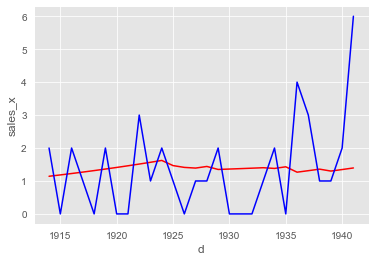

In [15]:
sns.lineplot(x='d', y='sales_y', data=res_rolling_28[res_rolling_28['id'] == 'FOODS_3_013_CA_2'], color='r')
sns.lineplot(x='d', y='sales_x', data=res_rolling_28[res_rolling_28['id'] == 'FOODS_3_013_CA_2'], color='b')
plt.show()

## 4.2 Train for the first 1941 days and forecast for the next 28 days

In [16]:
def roller_meaner_28(x):
    n=28
    for i in range(28):
        tmp = pd.DataFrame({ 'id':list(set(x.id)), 'd':[x.d.max() + 1], 'sales':[x.sales.tail(n).mean()]  })
        x = x.append(tmp, ignore_index=True )
    return x

with timer():
    the_rolling_28 = the_last28[['id','d','sales']].groupby('id', as_index=False).apply(roller_meaner_28).reset_index(drop=True)

with timer():
    res_rolling_28 = the_rolling_28.groupby('id', as_index=False ).tail(28)

print(res_rolling_28.shape)
print('-'*25)
res_rolling_28.tail()

Runtime: 927.6 sn
Runtime: 0.22 sn
(853720, 3)
-------------------------


,id,d,sales
1707435,HOUSEHOLD_2_516_WI_3,1965,0.053253
1707436,HOUSEHOLD_2_516_WI_3,1966,0.055155
1707437,HOUSEHOLD_2_516_WI_3,1967,0.057125
1707438,HOUSEHOLD_2_516_WI_3,1968,0.059165
1707439,HOUSEHOLD_2_516_WI_3,1969,0.061278


In [17]:
def roller_meaner_14(x):
    n=14
    for i in range(28):
        tmp = pd.DataFrame({ 'id':list(set(x.id)), 'd':[x.d.max() + 1], 'sales':[x.sales.tail(n).mean()]  })
        x = x.append(tmp, ignore_index=True )
    return x

with timer():
    the_rolling_14 = the_last28[['id','d','sales']].groupby('id', as_index=False).apply(roller_meaner_14).reset_index(drop=True)

with timer():
    res_rolling_14 = the_rolling_14.groupby('id', as_index=False ).tail(28)

print(res_rolling_14.shape)
print('-'*25)
res_rolling_14.tail()

Runtime: 937.0 sn
Runtime: 0.23 sn
(853720, 3)
-------------------------


,id,d,sales
1707435,HOUSEHOLD_2_516_WI_3,1965,0.056183
1707436,HOUSEHOLD_2_516_WI_3,1966,0.056979
1707437,HOUSEHOLD_2_516_WI_3,1967,0.057601
1707438,HOUSEHOLD_2_516_WI_3,1968,0.058021
1707439,HOUSEHOLD_2_516_WI_3,1969,0.058207


In [18]:
def roller_meaner_7(x):
    n=7
    for i in range(28):
        tmp = pd.DataFrame({ 'id':list(set(x.id)), 'd':[x.d.max() + 1], 'sales':[x.sales.tail(n).mean()]  })
        x = x.append(tmp, ignore_index=True )
    return x

with timer():
    the_rolling_7 = the_last28[['id','d','sales']].groupby('id', as_index=False).apply(roller_meaner_7).reset_index(drop=True)

with timer():
    res_rolling_7 = the_rolling_7.groupby('id', as_index=False ).tail(28)

print(res_rolling_7.shape)
print('-'*25)
res_rolling_7.tail()

Runtime: 1576.37 sn
Runtime: 0.22 sn
(853720, 3)
-------------------------


,id,d,sales
1707435,HOUSEHOLD_2_516_WI_3,1965,0.0
1707436,HOUSEHOLD_2_516_WI_3,1966,0.0
1707437,HOUSEHOLD_2_516_WI_3,1967,0.0
1707438,HOUSEHOLD_2_516_WI_3,1968,0.0
1707439,HOUSEHOLD_2_516_WI_3,1969,0.0


In [19]:
def basic_roller(roller):
    res_val  = the_last28[['id', 'd', 'sales']].copy()
    
    res_eval = res_val[['id','d']].copy()
    res_eval['d'] = res_eval['d'] + 28
    res_eval = res_eval.merge(roller, on=['id','d'], how='left')
    
    res_val['id']  = res_val['id']  + '_validation'
    res_eval['id'] = res_eval['id'] + '_evaluation'
    
    res_val             = res_val.pivot_table(index='id', columns='d', values='sales').reset_index()
    res_eval            = res_eval.pivot_table(index='id', columns='d', values='sales').reset_index()
    res_eval.columns    = res_val.columns
    
    
    res            = pd.concat([res_val, res_eval], axis=0, sort=False, ignore_index=True)
    res            = submission[['id']].merge(res, on='id', how='left')
    res.columns    = submission.columns
    
    # print(res.shape)
    # print('-'*25)
    # print(res.tail())
    
    return res

In [20]:
output = 'output/'

with timer():
    res_rolling_mean_28  = basic_roller(res_rolling_28)
    print(res_rolling_mean_28.shape)
    res_rolling_mean_28.to_csv(f'{output}M5_Forecasting_Basic_Roller_Mean_28.csv', index=False)
    
    res_rolling_mean_14  = basic_roller(res_rolling_14)
    res_rolling_mean_14.to_csv(f'{output}M5_Forecasting_Basic_Roller_Mean_14.csv', index=False)
    
    res_rolling_mean_7   = basic_roller(res_rolling_7)
    res_rolling_mean_7.to_csv(f'{output}M5_Forecasting_Basic_Roller_Mean_7.csv', index=False)

(60980, 29)
Runtime: 12.53 sn


# 5. THE ROLLING MEDIAN

In [21]:
def roller_medianer_28(x):
    n=28
    for i in range(28):
        tmp = pd.DataFrame({ 'id':list(set(x.id)), 'd':[x.d.max() + 1], 'sales':[x.sales.tail(n).median()]  })
        x = x.append(tmp, ignore_index=True )
    return x

with timer():
    the_rolling_28 = the_last28[['id','d','sales']].groupby('id', as_index=False).apply(roller_medianer_28).reset_index(drop=True)

with timer():
    res_rolling_28 = the_rolling_28.groupby('id', as_index=False ).tail(28)

print(res_rolling_28.shape)
print('-'*25)
res_rolling_28.tail()

Runtime: 956.34 sn
Runtime: 0.22 sn
(853720, 3)
-------------------------


,id,d,sales
1707435,HOUSEHOLD_2_516_WI_3,1965,0.0
1707436,HOUSEHOLD_2_516_WI_3,1966,0.0
1707437,HOUSEHOLD_2_516_WI_3,1967,0.0
1707438,HOUSEHOLD_2_516_WI_3,1968,0.0
1707439,HOUSEHOLD_2_516_WI_3,1969,0.0


In [22]:
def roller_medianer_14(x):
    n=14
    for i in range(28):
        tmp = pd.DataFrame({ 'id':list(set(x.id)), 'd':[x.d.max() + 1], 'sales':[x.sales.tail(n).median()]  })
        x = x.append(tmp, ignore_index=True )
    return x

with timer():
    the_rolling_14 = the_last28[['id','d','sales']].groupby('id', as_index=False).apply(roller_medianer_14).reset_index(drop=True)

with timer():
    res_rolling_14 = the_rolling_14.groupby('id', as_index=False ).tail(28)

print(res_rolling_14.shape)
print('-'*25)
res_rolling_14.tail()

Runtime: 966.84 sn
Runtime: 0.21 sn
(853720, 3)
-------------------------


,id,d,sales
1707435,HOUSEHOLD_2_516_WI_3,1965,0.0
1707436,HOUSEHOLD_2_516_WI_3,1966,0.0
1707437,HOUSEHOLD_2_516_WI_3,1967,0.0
1707438,HOUSEHOLD_2_516_WI_3,1968,0.0
1707439,HOUSEHOLD_2_516_WI_3,1969,0.0


In [23]:
def roller_medianer_7(x):
    n=7
    for i in range(28):
        tmp = pd.DataFrame({ 'id':list(set(x.id)), 'd':[x.d.max() + 1], 'sales':[x.sales.tail(n).median()]  })
        x = x.append(tmp, ignore_index=True )
    return x

with timer():
    the_rolling_7 = the_last28[['id','d','sales']].groupby('id', as_index=False).apply(roller_medianer_7).reset_index(drop=True)

with timer():
    res_rolling_7 = the_rolling_7.groupby('id', as_index=False ).tail(28)

print(res_rolling_7.shape)
print('-'*25)
res_rolling_7.tail()

Runtime: 938.08 sn
Runtime: 0.21 sn
(853720, 3)
-------------------------


,id,d,sales
1707435,HOUSEHOLD_2_516_WI_3,1965,0.0
1707436,HOUSEHOLD_2_516_WI_3,1966,0.0
1707437,HOUSEHOLD_2_516_WI_3,1967,0.0
1707438,HOUSEHOLD_2_516_WI_3,1968,0.0
1707439,HOUSEHOLD_2_516_WI_3,1969,0.0


In [24]:
output = 'output/'

with timer():
    res_rolling_median_28  = basic_roller(res_rolling_28)
    print(res_rolling_median_28.shape)
    res_rolling_median_28.to_csv(f'{output}M5_Forecasting_Basic_Roller_Median_28.csv', index=False)
    
    res_rolling_median_14  = basic_roller(res_rolling_14)
    res_rolling_median_14.to_csv(f'{output}M5_Forecasting_Basic_Roller_Median_14.csv', index=False)
    
    res_rolling_median_7   = basic_roller(res_rolling_7)
    res_rolling_median_7.to_csv(f'{output}M5_Forecasting_Basic_Roller_Median_7.csv', index=False)

(60980, 29)
Runtime: 8.47 sn
